In [15]:
from tqdm.contrib import itertools
from simulation_util import calc_frequency

In [16]:
import math
from EduKTM import DKT, AKT, DKVMN
import torch
import torch.utils.data as Data
from dkt.loader import sequences2tl, transform_sim_data, parse_all_seq, encode_onehot
from tqdm import tqdm
from akt.load_data import DATA, PID_DATA
from dkvmn.load_data import Data as Data_DKVMN
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_QUESTIONS = 9
HIDDEN_SIZE = 10
NUM_LAYERS = 1
BATCH_SIZE = 64

dkt = DKT(NUM_QUESTIONS, HIDDEN_SIZE, NUM_LAYERS)
dkt.load("dkt.params")
dkt_model = dkt.dkt_model
dkt_model.eval()


def get_task_with_dkt_model(simulation_log, dql_model):
    transformed_data = transform_sim_data(simulation_log, dql_model).dropna(subset=['skill_id'])
    data = parse_all_seq(transformed_data)
    encoded = encode_onehot(data, NUM_QUESTIONS)
    data_loader = Data.DataLoader(encoded, shuffle=True)
    
    for batch in data_loader:
        integrated_pred = dkt_model(batch.to(torch.float32))
        task_count = integrated_pred.shape[1]
    return {
        category: [
            calc_frequency(
                integrated_pred[0][task_count-1][(category_i * len(dql_model[category])) + i].item()
            ) for i in range(len(dql_model[category]))
        ] for category_i, category in enumerate(dql_model)
    }
    
params = {
    'max_iter': 3, # 'number of iterations'
    'init_std': 0.1, # 'weight initialization std'
    'init_lr': 0.01, # 'initial learning rate'
    'lr_decay': 0.75, # 'learning rate decay'
    'final_lr': 1E-5, # 'learning rate will not decrease after hitting this threshold'
    'momentum': 0.9, # 'momentum rate'
    'maxgradnorm': 50.0, # 'maximum gradient norm'
    'final_fc_dim': 50, # 'hidden state dim for final fc layer'
    'key_embedding_dim': 50, # 'question embedding dimensions'
    'batch_size': 64, # 'the batch size'
    'value_embedding_dim': 200, # 'answer and question embedding dimensions'
    'memory_size': 20, # 'memory size'
    'n_question': NUM_QUESTIONS, # 'the number of unique questions in the dataset'
    'seqlen': 900, # 'the allowed maximum length of a sequence'
    'data_name': '', # 'data set name'
    'load': 'dkvmn.params', # 'model file to load'
    'save': 'dkvmn.params' # 'path to save model'
}

params['lr'] = params['init_lr']
params['key_memory_state_dim'] = params['key_embedding_dim']
params['value_memory_state_dim'] = params['value_embedding_dim']

dat = Data_DKVMN(n_question=NUM_QUESTIONS, seqlen=params['seqlen'], separate_char=',')
dkvmn = DKVMN(n_question=NUM_QUESTIONS,
                batch_size=params['batch_size'],
                key_embedding_dim=params['key_embedding_dim'],
                value_embedding_dim=params['value_embedding_dim'],
                memory_size=params['memory_size'],
                key_memory_state_dim=params['key_memory_state_dim'],
                value_memory_state_dim=params['value_memory_state_dim'],
                final_fc_dim=params['final_fc_dim']) 
dkvmn.load(params['load'])
dkvmn_model = dkvmn.model
dkvmn_model.eval()

def load_data_from_sequences(data_array):
    q_data = []
    qa_data = []
    
    for Q, A in data_array:
        # Process each sequence
        n_split = 1
        if len(Q) > params['seqlen']:
            n_split = math.floor(len(Q) / params['seqlen'])
            if len(Q) % params['seqlen']:
                n_split = n_split + 1
        
        for k in range(n_split):
            question_sequence = []
            answer_sequence = []
            if k == n_split - 1:
                end_index = len(A)
            else:
                end_index = (k+1) * params['seqlen']
            
            for i in range(k * params['seqlen'], end_index):
                # int(A[i]) is in {0,1}
                Xindex = int(Q[i]) + int(A[i]) * NUM_QUESTIONS
                question_sequence.append(int(Q[i]))
                answer_sequence.append(Xindex)
            
            q_data.append(question_sequence)
            qa_data.append(answer_sequence)
    
    # Convert to numpy arrays
    q_data_array = np.zeros((len(q_data), params['seqlen']))
    for j in range(len(q_data)):
        dat = q_data[j]
        q_data_array[j, :len(dat)] = dat

    qa_data_array = np.zeros((len(qa_data), params['seqlen']))
    for j in range(len(qa_data)):
        dat = qa_data[j]
        qa_data_array[j, :len(dat)] = dat
    
    return q_data_array, qa_data_array

def get_task_with_dkvmn_model(simulation_log, dql_model):
    #TODO: Try adding padding at the end of the sequence
    transformed_data = transform_sim_data(simulation_log, dql_model)
    sequences = parse_all_seq(transformed_data)
    # Add 1 to each element in sequences[0][0] (skill IDs)
    # This is needed because DKVMN expects skill IDs starting from 1 not 0
    # for i in range(len(sequences[0][0])):
    #     # l = len(sequences[0][0])
    #     sequences[0][0][i] += 1

    q_data, qa_data = load_data_from_sequences(sequences)
    
    target = qa_data

    target = (target - 1) / params['n_question']
    target = np.floor(target)

    input_q = torch.LongTensor(q_data).to(device)
    input_qa = torch.LongTensor(qa_data).to(device)
    target = torch.FloatTensor(target).to(device)
    target_1d = target.permute(1, 0)


    loss, filtered_pred, filtered_target = dkvmn_model.forward(input_q, input_qa, target_1d)
    right_pred = np.asarray(filtered_pred.data.tolist())
    print("right_pred", right_pred)
    right_target = np.asarray(filtered_target.data.tolist())


    return {
        category: [
            calc_frequency(
                right_pred[(len(right_pred) - NUM_QUESTIONS)+(category_i * len(dql_model[category])) + i].item()
            ) for i in range(len(dql_model[category]))
        ] for category_i, category in enumerate(dql_model)
    }


batch_size = 64
model_type = 'pid'
n_question = NUM_QUESTIONS
n_pid = 300724
seqlen = 900
n_blocks = 1
d_model = 256
dropout = 0.05
kq_same = 1
l2 = 1e-5
maxgradnorm = -1

# akt = AKT(n_question, n_pid, n_blocks, d_model, dropout, kq_same, l2, batch_size, maxgradnorm)
# akt.load("akt.params")
# akt_model = akt.akt_net
# akt_model.eval()

def get_competency_with_akt_model(simulation_log, dql_model):
    return

In [17]:
from simulation_util import add_delta_to_competency, calc_task_complexities, calculate_delta, calculate_solved, create_learner_population, create_learner_scaffolded_competence_bonuses, create_optimal_task, create_random_task
from simulation_const import DQL_MODEL

MAX_TASK_COUNT = 100

def simulate_task_adaptation(learner_count: int, bonus_distribution: tuple[float, float, float, float], type: str = "optimal"):
    """
    Simulate task adaptation with different strategies for task creation.
    
    Args:
        learner_count: Number of learners to simulate
        mean_competency: Mean competency level for the learner population
        bonus_distribution: Tuple of 4 values for scaffolding bonus distribution
        task_type: Strategy for task creation ("optimal", "random", "dkt", "dkvmn" or "akt")
    """
    if type not in ["optimal", "random", "dkt", "dkvmn", "akt"]:
        raise ValueError("task_type must be one of: optimal, random, dkt, dkvmn, akt")

    learner_population = create_learner_population(
        learner_count, MAX_TASK_COUNT, DQL_MODEL,  bonus_distribution)

    simulationLog = []
    simulationLog = [{
        "tasks": [],
        "competencies": [],
        "scaffolding_bonuses": [],
        "deltas": []
    } for _ in range(learner_count)]

    for l, t in itertools.product(range(learner_count), range(MAX_TASK_COUNT)):
            learner_competency = learner_population["learner_competencies"][l]
            scaffolding_bonus = learner_population["scaffolding_competence_bonus_per_step_and_learner"][t][l]
        
            # Create task based on selected strategy
            if type == "optimal":
                task = create_optimal_task(DQL_MODEL, learner_competency, scaffolding_bonus)
            elif type == "random":
                task = create_random_task(DQL_MODEL)
            elif type == "dkt":
                # First task is random since there's no previous data
                if t == 0:
                    task = create_random_task(DQL_MODEL)
                else:
                    task = get_task_with_dkt_model([simulationLog[l]], DQL_MODEL)
            elif type == "dkvmn":
                # First task is random since there's no previous data
                if t == 0:
                    task = create_random_task(DQL_MODEL)
                else:
                    task = get_task_with_dkvmn_model([simulationLog[l]], DQL_MODEL)
            else:
                break

            task_complexities = calc_task_complexities(task)

            # print(task_solved)
        
            delta = calculate_delta(
                learner_competency, task_complexities, scaffolding_bonus)

            # Update learner competency        
            learner_population["learner_competencies"][l] = add_delta_to_competency(
                learner_competency, delta)
            
            simulationLog[l]["tasks"].append(task)
            simulationLog[l]["competencies"].append(learner_population["learner_competencies"][l])
            simulationLog[l]["scaffolding_bonuses"].append(scaffolding_bonus)
            simulationLog[l]["deltas"].append(delta)
            
    return simulationLog

In [18]:
log_optimal = simulate_task_adaptation(100, (0.1, 0.002, 0, 0.2), type="optimal")
log_random = simulate_task_adaptation(100, (0.1, 0.002, 0, 0.2), type="random")
# log_dkt = simulate_task_adaptation(100, (0.1, 0.002, 0, 0.2), type="dkt")
log_dkvmn = simulate_task_adaptation(10, (0.1, 0.002, 0, 0.2), type="dkvmn")
# akt_log = simulate_task_adaptation(100, (0.1, 0.002, 0, 0.2), type="akt")


  0%|          | 3/1000 [00:00<00:55, 18.05it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251]
right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164]
right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.44865584]


  1%|          | 7/1000 [00:00<01:13, 13.49it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578]
right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885]
right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.4

  1%|          | 9/1000 [00:00<01:16, 12.94it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811]
right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37

  1%|▏         | 13/1000 [00:00<01:18, 12.59it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628]
right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.4358

  2%|▏         | 15/1000 [00:01<01:18, 12.47it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  2%|▏         | 19/1000 [00:01<01:19, 12.40it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  2%|▏         | 21/1000 [00:01<01:19, 12.34it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  2%|▏         | 23/1000 [00:01<01:19, 12.30it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  3%|▎         | 27/1000 [00:02<01:23, 11.66it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  3%|▎         | 29/1000 [00:02<01:22, 11.83it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  3%|▎         | 33/1000 [00:02<01:20, 12.04it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  4%|▎         | 35/1000 [00:02<01:19, 12.07it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  4%|▍         | 39/1000 [00:03<01:19, 12.16it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  4%|▍         | 41/1000 [00:03<01:18, 12.18it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  4%|▍         | 45/1000 [00:03<01:18, 12.18it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  5%|▍         | 47/1000 [00:03<01:18, 12.17it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  5%|▍         | 49/1000 [00:03<01:18, 12.12it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  5%|▌         | 53/1000 [00:04<01:22, 11.55it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  6%|▌         | 55/1000 [00:04<01:20, 11.72it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  6%|▌         | 59/1000 [00:04<01:18, 11.94it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  6%|▌         | 61/1000 [00:05<01:18, 11.98it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  6%|▋         | 65/1000 [00:05<01:17, 12.04it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  7%|▋         | 67/1000 [00:05<01:17, 12.05it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  7%|▋         | 71/1000 [00:05<01:16, 12.07it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  7%|▋         | 73/1000 [00:06<01:16, 12.06it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  8%|▊         | 75/1000 [00:06<01:22, 11.19it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  8%|▊         | 79/1000 [00:06<01:22, 11.15it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  8%|▊         | 81/1000 [00:06<01:20, 11.38it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  8%|▊         | 85/1000 [00:07<01:18, 11.69it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  9%|▊         | 87/1000 [00:07<01:18, 11.60it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  9%|▉         | 91/1000 [00:07<01:17, 11.77it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

  9%|▉         | 93/1000 [00:07<01:22, 10.98it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

 10%|▉         | 97/1000 [00:08<01:19, 11.39it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

 10%|▉         | 99/1000 [00:08<01:18, 11.55it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.45149648 0.38589507 0.41014215
 0.43582264 0.42107251 0.00145268 0.41060466 0.42790225 0.35180709
 0.49047536 0.38967708 0.40986016 0.45141855 0.46482164 0.44693163
 0.45843264 0.41897973 0.4417983  0.44857946 0.44944361 0.44257477
 0.4486559  0.33622876 0.35439393 0.38043559 0.33792672 0.38019186
 0.37381282 0.35045141 0.33866578 0.31288049 0.22707514 0.29701012
 0.24220082 0.27999955 0.28980485 0.26135257 0.24682885 0.22587605
 0.2694236  0.20206229 0.15496886 0.18190163 0.19151451 0.17247945
 0.15802152 0.14810933 0.17498678 0.13730927 0.10511352 0.12087829
 0.12924404 0.11865972 0.10715811 0.10186528 0.11838629 0.0981833
 0.07676513 0.08547841 0.09292655 0.08727209 0.07835472 0.07481172
 0.08695621 0.07454255 0.05991399 0.0645608  0.07135353 0.06839252
 0.06131656 0.05839388 0.06883059 0.05974434 0.04936262 0.0516578
 0.05796359 0.05650123 0.05069628 0.04795107 0.05777336 0.05008587
 0.04243689 0.04332849 0.04926636 0.04867196 0.043753

 10%|█         | 104/1000 [00:08<01:08, 13.12it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513]


 11%|█         | 106/1000 [00:08<01:11, 12.51it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542

 11%|█         | 108/1000 [00:08<01:14, 11.97it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565

 11%|█         | 112/1000 [00:09<01:18, 11.35it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.344165

 11%|█▏        | 114/1000 [00:09<01:16, 11.57it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 12%|█▏        | 118/1000 [00:09<01:14, 11.85it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 12%|█▏        | 120/1000 [00:10<01:13, 11.96it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 12%|█▏        | 124/1000 [00:10<01:12, 12.13it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 13%|█▎        | 126/1000 [00:10<01:17, 11.30it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 13%|█▎        | 130/1000 [00:10<01:17, 11.27it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 13%|█▎        | 132/1000 [00:11<01:18, 11.10it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 14%|█▎        | 136/1000 [00:11<01:14, 11.60it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 14%|█▍        | 138/1000 [00:11<01:13, 11.78it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 14%|█▍        | 142/1000 [00:11<01:15, 11.35it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 14%|█▍        | 144/1000 [00:12<01:13, 11.59it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 15%|█▍        | 148/1000 [00:12<01:11, 11.90it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 15%|█▌        | 150/1000 [00:12<01:10, 11.97it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 15%|█▌        | 154/1000 [00:12<01:10, 12.06it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 16%|█▌        | 156/1000 [00:13<01:15, 11.23it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 16%|█▌        | 160/1000 [00:13<01:12, 11.65it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 16%|█▌        | 162/1000 [00:13<01:11, 11.78it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 17%|█▋        | 166/1000 [00:14<01:10, 11.88it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 17%|█▋        | 168/1000 [00:14<01:09, 11.94it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 17%|█▋        | 170/1000 [00:14<01:17, 10.69it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 17%|█▋        | 174/1000 [00:14<01:12, 11.32it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 18%|█▊        | 176/1000 [00:14<01:11, 11.52it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 18%|█▊        | 180/1000 [00:15<01:09, 11.74it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 18%|█▊        | 182/1000 [00:15<01:14, 10.99it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 19%|█▊        | 186/1000 [00:15<01:10, 11.49it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 19%|█▉        | 188/1000 [00:15<01:09, 11.61it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 19%|█▉        | 192/1000 [00:16<01:08, 11.76it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 19%|█▉        | 194/1000 [00:16<01:20, 10.07it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 20%|█▉        | 196/1000 [00:16<01:17, 10.38it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 20%|██        | 200/1000 [00:17<01:16, 10.52it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.42260647 0.41887507 0.38289851 0.3640154
 0.37816408 0.39666253 0.42542472 0.34416553 0.43388039 0.36642793
 0.42986771 0.4244366  0.44034243 0.43724707 0.43155685 0.42225513
 0.32945374 0.37991092 0.333866   0.34160963 0.34815985 0.33042181
 0.31539008 0.33565357 0.2129564  0.25943759 0.22273666 0.2225161
 0.22935064 0.21678911 0.20639248 0.21806869 0.13844129 0.16719432
 0.14832228 0.14341106 0.14858423 0.14363816 0.13805291 0.14135873
 0.09576216 0.11486086 0.1042046  0.09840773 0.10136224 0.10123617
 0.09852269 0.09780814 0.07098281 0.08560331 0.07800312 0.07268291
 0.07397577 0.07637182 0.07521543 0.07286046 0.05591242 0.06843706
 0.06183747 0.05728015 0.05750077 0.06114588 0.0608387  0.05788663
 0.04627892 0.05778789 0.05140981 0.0475713  0.0471199  0.05137406
 0.05154663 0.04843175 0.03984094 0.050849   0.04440091 0.04116403
 0.04028543 0.04483408 0.0452892  0.04218671 0.035374

 20%|██        | 203/1000 [00:17<01:05, 12.24it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259]


 20%|██        | 205/1000 [00:17<01:09, 11.50it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101 ]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104  ]


 21%|██        | 209/1000 [00:17<01:13, 10.82it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457 ]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104 

 21%|██        | 211/1000 [00:18<01:16, 10.31it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904  ]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273

 22%|██▏       | 215/1000 [00:18<01:13, 10.75it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 22%|██▏       | 217/1000 [00:18<01:14, 10.45it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 22%|██▏       | 219/1000 [00:18<01:11, 10.88it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 22%|██▏       | 223/1000 [00:19<01:14, 10.40it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 22%|██▎       | 225/1000 [00:19<01:11, 10.88it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 23%|██▎       | 229/1000 [00:19<01:19,  9.68it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 23%|██▎       | 231/1000 [00:20<01:15, 10.22it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 24%|██▎       | 235/1000 [00:20<01:08, 11.10it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 24%|██▎       | 237/1000 [00:20<01:07, 11.38it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 24%|██▍       | 239/1000 [00:20<01:10, 10.76it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 24%|██▍       | 241/1000 [00:20<01:08, 11.02it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 24%|██▍       | 245/1000 [00:21<01:07, 11.12it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 25%|██▍       | 247/1000 [00:21<01:07, 11.18it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 25%|██▌       | 251/1000 [00:21<01:07, 11.03it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 25%|██▌       | 253/1000 [00:22<01:06, 11.30it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 26%|██▌       | 257/1000 [00:22<01:03, 11.64it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 26%|██▌       | 259/1000 [00:22<01:20,  9.22it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 26%|██▋       | 263/1000 [00:23<01:12, 10.17it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 26%|██▋       | 265/1000 [00:23<01:09, 10.59it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 27%|██▋       | 267/1000 [00:23<01:07, 10.88it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 27%|██▋       | 271/1000 [00:23<01:07, 10.85it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 27%|██▋       | 273/1000 [00:23<01:05, 11.15it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 28%|██▊       | 277/1000 [00:24<01:02, 11.52it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 28%|██▊       | 279/1000 [00:24<01:06, 10.81it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 28%|██▊       | 283/1000 [00:24<01:03, 11.32it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 28%|██▊       | 285/1000 [00:24<01:02, 11.46it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 29%|██▉       | 289/1000 [00:25<01:04, 11.11it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 29%|██▉       | 291/1000 [00:25<01:02, 11.32it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 30%|██▉       | 295/1000 [00:25<01:02, 11.22it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 30%|██▉       | 297/1000 [00:26<01:08, 10.32it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 30%|███       | 302/1000 [00:26<00:55, 12.69it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.51564908 0.51812273 0.41854107 0.41270572
 0.42147073 0.394274   0.44142652 0.41575423 0.42859352 0.42982259
 0.30599436 0.30524594 0.31956553 0.27306926 0.33964026 0.32764837
 0.29134616 0.2821101  0.19460632 0.19359565 0.20951729 0.17128457
 0.21970032 0.21273395 0.18837358 0.177104   0.14481699 0.15824412
 0.16145879 0.13239168 0.16084255 0.16237433 0.15363628 0.1753457
 0.09939137 0.11090403 0.111854   0.09225093 0.10830075 0.11218375
 0.1076189  0.1176094  0.07312644 0.08394794 0.08255613 0.06916286
 0.07800059 0.08292633 0.0806808  0.0844228  0.05724413 0.06780771
 0.06466614 0.05518081 0.05994968 0.06524476 0.06427169 0.064904
 0.04714653 0.05761842 0.0532457  0.04626579 0.04868435 0.0540508
 0.05379768 0.05287992 0.04042949 0.05088389 0.0456394  0.04032247
 0.04132859 0.0466491  0.0468208  0.0451191  0.03578756 0

 30%|███       | 304/1000 [00:26<00:55, 12.57it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483]


 31%|███       | 308/1000 [00:27<00:58, 11.74it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.2090665

 31%|███       | 310/1000 [00:27<00:58, 11.87it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.4554341

 31%|███▏      | 314/1000 [00:27<00:57, 12.01it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 32%|███▏      | 316/1000 [00:27<01:01, 11.21it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 32%|███▏      | 318/1000 [00:27<00:59, 11.45it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 32%|███▏      | 322/1000 [00:28<01:09,  9.71it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 32%|███▏      | 324/1000 [00:28<01:15,  9.00it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 33%|███▎      | 326/1000 [00:28<01:14,  9.00it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 33%|███▎      | 327/1000 [00:28<01:13,  9.17it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 33%|███▎      | 331/1000 [00:29<01:18,  8.51it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 34%|███▎      | 335/1000 [00:29<01:05, 10.10it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 34%|███▎      | 337/1000 [00:29<01:02, 10.61it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 34%|███▍      | 339/1000 [00:30<01:00, 10.93it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 34%|███▍      | 341/1000 [00:30<01:04, 10.29it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 34%|███▍      | 345/1000 [00:30<01:01, 10.68it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 35%|███▍      | 347/1000 [00:30<00:59, 11.04it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 35%|███▍      | 349/1000 [00:31<01:04, 10.05it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 35%|███▌      | 351/1000 [00:31<01:18,  8.30it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 36%|███▌      | 355/1000 [00:31<01:05,  9.82it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 36%|███▌      | 357/1000 [00:32<01:05,  9.76it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 36%|███▌      | 361/1000 [00:32<00:59, 10.75it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 36%|███▋      | 363/1000 [00:32<00:57, 11.08it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 36%|███▋      | 365/1000 [00:32<01:00, 10.52it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 37%|███▋      | 369/1000 [00:33<00:59, 10.69it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 37%|███▋      | 371/1000 [00:33<00:57, 11.02it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 38%|███▊      | 375/1000 [00:33<00:57, 10.91it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 38%|███▊      | 377/1000 [00:33<00:55, 11.16it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 38%|███▊      | 379/1000 [00:34<00:57, 10.75it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 38%|███▊      | 382/1000 [00:34<01:07,  9.18it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 39%|███▊      | 386/1000 [00:34<00:58, 10.44it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 39%|███▉      | 388/1000 [00:34<01:00, 10.09it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 39%|███▉      | 392/1000 [00:35<00:55, 10.88it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 39%|███▉      | 394/1000 [00:35<00:54, 11.12it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 40%|███▉      | 396/1000 [00:35<00:57, 10.55it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 40%|████      | 400/1000 [00:36<00:54, 11.06it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.00149135 0.48286378 0.50441581 0.47177497
 0.52918947 0.41865468 0.46461836 0.48229772 0.43792969 0.4483805
 0.46554983 0.44154999 0.42388681 0.44845086 0.45543411 0.45243856
 0.45711252 0.34873742 0.33157051 0.35855931 0.36367375 0.36173135
 0.34424162 0.34764895 0.32951483 0.22700579 0.24534287 0.28141651
 0.27965757 0.27332792 0.31149814 0.29919618 0.26994452 0.26117393
 0.18631585 0.21818714 0.21025223 0.2568031  0.20906655 0.20090079
 0.17335661 0.17286474 0.12754297 0.14770111 0.1383063  0.17360185
 0.14048809 0.13620591 0.11632235 0.1169273  0.09412012 0.10448689
 0.09620991 0.11776756 0.09986864 0.09788382 0.08390006 0.08393685
 0.07434483 0.07840575 0.07168234 0.08413714 0.07574115 0.07500217
 0.06481568 0.06411314 0.06202354 0.06218603 0.05680435 0.06386708
 0.06084483 0.06078579 0.05300429 0.05168565 0.05397274 0.0516819
 0.04734154 0.05123344 0.05123159 0.0515566  0.0453364

 40%|████      | 404/1000 [00:36<00:49, 12.16it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408 ]


 41%|████      | 406/1000 [00:36<00:48, 12.13it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 

 41%|████      | 408/1000 [00:36<00:48, 12.10it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794

 41%|████      | 412/1000 [00:37<00:51, 11.52it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727

 41%|████▏     | 414/1000 [00:37<00:50, 11.69it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 42%|████▏     | 416/1000 [00:37<00:49, 11.75it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 42%|████▏     | 420/1000 [00:37<00:53, 10.78it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 42%|████▏     | 422/1000 [00:38<00:57, 10.10it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 42%|████▏     | 424/1000 [00:38<00:59,  9.73it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 43%|████▎     | 426/1000 [00:38<00:56, 10.22it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 43%|████▎     | 428/1000 [00:38<00:53, 10.61it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 43%|████▎     | 432/1000 [00:39<00:57,  9.96it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 43%|████▎     | 434/1000 [00:39<01:10,  8.01it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 44%|████▎     | 437/1000 [00:39<01:07,  8.31it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 44%|████▍     | 440/1000 [00:40<01:04,  8.65it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 44%|████▍     | 442/1000 [00:40<00:58,  9.46it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 44%|████▍     | 445/1000 [00:40<00:56,  9.80it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 45%|████▍     | 448/1000 [00:40<00:53, 10.30it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 45%|████▌     | 450/1000 [00:41<00:57,  9.63it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 45%|████▌     | 454/1000 [00:41<00:52, 10.47it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 46%|████▌     | 456/1000 [00:41<00:52, 10.42it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 46%|████▌     | 459/1000 [00:42<01:08,  7.90it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 46%|████▋     | 463/1000 [00:42<00:57,  9.34it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 46%|████▋     | 464/1000 [00:42<00:57,  9.32it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 47%|████▋     | 467/1000 [00:42<00:58,  9.14it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 47%|████▋     | 471/1000 [00:43<00:50, 10.44it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 47%|████▋     | 473/1000 [00:43<00:48, 10.86it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 48%|████▊     | 477/1000 [00:43<00:46, 11.36it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 48%|████▊     | 479/1000 [00:44<00:45, 11.51it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 48%|████▊     | 483/1000 [00:44<00:44, 11.63it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 48%|████▊     | 485/1000 [00:44<00:47, 10.84it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 49%|████▉     | 489/1000 [00:44<00:45, 11.29it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 49%|████▉     | 491/1000 [00:45<00:47, 10.66it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 49%|████▉     | 493/1000 [00:45<00:49, 10.17it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 50%|████▉     | 497/1000 [00:45<00:56,  8.94it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 50%|████▉     | 499/1000 [00:46<00:55,  9.01it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 50%|█████     | 502/1000 [00:46<00:44, 11.30it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.47619385 0.50564313 0.49987164 0.46789727 0.44947445 0.46643388
 0.44657591 0.44450694 0.4555411  0.45516989 0.45383292 0.4499408
 0.32739276 0.32792246 0.34936172 0.29711965 0.35902154 0.35032362
 0.33547977 0.30860794 0.20963135 0.24225096 0.27222154 0.22243227
 0.26948681 0.26689318 0.25105321 0.22044274 0.21744746 0.15776217
 0.18010899 0.1431531  0.17354482 0.17441942 0.16516475 0.14208803
 0.14291494 0.11071092 0.1231401  0.09853396 0.11575801 0.11914836
 0.11439885 0.09823495 0.09902349 0.08396147 0.08945651 0.07299501
 0.08244063 0.08708166 0.08480773 0.0732158  0.07323673 0.06791813
 0.06904811 0.05764002 0.06270783 0.06785214 0.06690758 0.05820205
 0.05747938 0.05776408 0.05614707 0.04791838 0.05047815 0.05576907
 0.05555976 0.04870942 0.04739168 0.05103483 0.04763476 0.04147664
 0.04254458 0.04783006 0.04804518 0.04242761 0.0406497

 50%|█████     | 504/1000 [00:46<00:50,  9.75it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242]


 51%|█████     | 507/1000 [00:46<00:59,  8.23it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626]


 51%|█████     | 509/1000 [00:47<00:53,  9.12it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0

 51%|█████     | 511/1000 [00:47<00:49,  9.86it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504

 52%|█████▏    | 515/1000 [00:47<00:47, 10.32it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 52%|█████▏    | 517/1000 [00:47<00:55,  8.75it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 52%|█████▏    | 519/1000 [00:48<01:01,  7.81it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 52%|█████▏    | 521/1000 [00:48<00:55,  8.69it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 52%|█████▏    | 524/1000 [00:48<00:53,  8.92it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 53%|█████▎    | 526/1000 [00:48<00:48,  9.76it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 53%|█████▎    | 528/1000 [00:49<00:45, 10.27it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 53%|█████▎    | 532/1000 [00:49<00:45, 10.39it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 53%|█████▎    | 534/1000 [00:49<00:47,  9.86it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 54%|█████▎    | 536/1000 [00:50<00:51,  9.04it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 54%|█████▍    | 539/1000 [00:50<00:49,  9.23it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 54%|█████▍    | 541/1000 [00:50<00:49,  9.30it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 54%|█████▍    | 543/1000 [00:50<00:44, 10.17it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 55%|█████▍    | 546/1000 [00:51<00:44, 10.12it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 55%|█████▍    | 548/1000 [00:51<00:42, 10.62it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 55%|█████▌    | 550/1000 [00:51<00:44, 10.05it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 55%|█████▌    | 552/1000 [00:51<00:42, 10.46it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 56%|█████▌    | 556/1000 [00:51<00:42, 10.47it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 56%|█████▌    | 558/1000 [00:52<00:41, 10.77it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 56%|█████▌    | 560/1000 [00:52<00:43, 10.18it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 56%|█████▌    | 562/1000 [00:52<00:41, 10.49it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 57%|█████▋    | 566/1000 [00:52<00:41, 10.42it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 57%|█████▋    | 568/1000 [00:53<00:40, 10.72it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 57%|█████▋    | 570/1000 [00:53<00:42, 10.18it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 57%|█████▋    | 572/1000 [00:53<00:40, 10.46it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 58%|█████▊    | 576/1000 [00:53<00:40, 10.45it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 58%|█████▊    | 578/1000 [00:54<00:39, 10.73it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 58%|█████▊    | 580/1000 [00:54<00:41, 10.04it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 58%|█████▊    | 582/1000 [00:54<00:40, 10.36it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 59%|█████▊    | 586/1000 [00:54<00:40, 10.28it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 59%|█████▉    | 588/1000 [00:55<00:39, 10.55it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 59%|█████▉    | 590/1000 [00:55<00:40, 10.01it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 59%|█████▉    | 592/1000 [00:55<00:39, 10.29it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 60%|█████▉    | 596/1000 [00:55<00:39, 10.29it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 60%|█████▉    | 598/1000 [00:56<00:37, 10.59it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 60%|██████    | 600/1000 [00:56<00:39, 10.02it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.49428537 0.50896972 0.48347092 0.5284434
 0.43055445 0.47497168 0.49155319 0.48874608 0.43446457 0.43612379
 0.43107954 0.43318266 0.44599575 0.4306902  0.4169215  0.42655393
 0.30387977 0.28771245 0.30822235 0.32876804 0.32625705 0.295616
 0.28118283 0.28099242 0.19379967 0.18304846 0.20212625 0.21116948
 0.21073376 0.1907956  0.18221542 0.17663009 0.12739201 0.12443591
 0.13577726 0.13669623 0.13727559 0.12822545 0.12387428 0.11724626
 0.08952917 0.09176564 0.09685061 0.09460487 0.0948474  0.09229143
 0.09028403 0.08408023 0.06732758 0.07261991 0.07357134 0.07044496
 0.07012861 0.07100095 0.07024397 0.06475004 0.05365734 0.0607494
 0.0590488  0.05588963 0.05512473 0.05777116 0.05769716 0.05286041
 0.0448194  0.05301485 0.04957812 0.04666169 0.04558358 0.04916031
 0.04947483 0.04517475 0.03885644 0.04776577 0.04315139 0.04054233
 0.03925078 0.04332712 0.04387228 0.03999449 0.03468756 

 60%|██████    | 603/1000 [00:56<00:33, 12.03it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103]
right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368]


 61%|██████    | 607/1000 [00:56<00:34, 11.32it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917]
right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281]
right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.4

 61%|██████    | 609/1000 [00:56<00:34, 11.44it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429]
right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.38

 61%|██████    | 611/1000 [00:57<00:36, 10.66it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583]
right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37

 61%|██████▏   | 613/1000 [00:57<00:35, 10.86it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 62%|██████▏   | 617/1000 [00:57<00:35, 10.68it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 62%|██████▏   | 619/1000 [00:57<00:34, 10.98it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 62%|██████▏   | 621/1000 [00:58<00:36, 10.34it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 62%|██████▏   | 623/1000 [00:58<00:35, 10.64it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 63%|██████▎   | 627/1000 [00:58<00:35, 10.54it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 63%|██████▎   | 629/1000 [00:58<00:34, 10.81it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 63%|██████▎   | 631/1000 [00:59<00:36, 10.24it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 64%|██████▎   | 635/1000 [00:59<00:35, 10.34it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 64%|██████▎   | 637/1000 [00:59<00:33, 10.69it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 64%|██████▍   | 641/1000 [01:00<00:33, 10.57it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 64%|██████▍   | 643/1000 [01:00<00:32, 10.84it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 65%|██████▍   | 647/1000 [01:00<00:34, 10.13it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 65%|██████▍   | 649/1000 [01:00<00:33, 10.50it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 65%|██████▌   | 653/1000 [01:01<00:33, 10.22it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 66%|██████▌   | 655/1000 [01:01<00:32, 10.58it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 66%|██████▌   | 659/1000 [01:01<00:33, 10.05it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 66%|██████▌   | 661/1000 [01:02<00:32, 10.44it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 66%|██████▋   | 663/1000 [01:02<00:33,  9.94it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 66%|██████▋   | 665/1000 [01:02<00:32, 10.27it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 67%|██████▋   | 669/1000 [01:02<00:32, 10.23it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 67%|██████▋   | 671/1000 [01:03<00:33,  9.85it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 67%|██████▋   | 673/1000 [01:03<00:32, 10.20it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 68%|██████▊   | 677/1000 [01:03<00:31, 10.21it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 68%|██████▊   | 679/1000 [01:03<00:32,  9.80it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 68%|██████▊   | 681/1000 [01:04<00:31, 10.10it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 68%|██████▊   | 685/1000 [01:04<00:30, 10.19it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 69%|██████▊   | 687/1000 [01:04<00:31,  9.79it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 69%|██████▉   | 689/1000 [01:04<00:30, 10.15it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 69%|██████▉   | 693/1000 [01:05<00:30, 10.03it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 70%|██████▉   | 695/1000 [01:05<00:31,  9.67it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 70%|██████▉   | 699/1000 [01:05<00:28, 10.47it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 70%|███████   | 703/1000 [01:06<00:25, 11.65it/s]

right_pred [0.00195243 0.45198444 0.41105843 0.42218074 0.44916561 0.39322349
 0.41697785 0.43563688 0.42383566 0.44119504 0.47408757 0.35035077
 0.48150873 0.3952938  0.37571761 0.41394326 0.39340103 0.42104363
 0.35250524 0.3654812  0.45230901 0.35815805 0.41996384 0.42538637
 0.44844368 0.37393427 0.40093744 0.37623501 0.34823367 0.37936118
 0.3807416  0.37311688 0.35739917 0.2549988  0.29134539 0.28744695
 0.22534125 0.29820153 0.26763961 0.26087072 0.23298281 0.16481981
 0.18836541 0.19517654 0.14552446 0.20002781 0.17636605 0.17277847
 0.15016143 0.11117475 0.12731701 0.13336699 0.10003942 0.13289416
 0.12059663 0.11912274 0.10299429 0.08018353 0.09309461 0.09595676
 0.07391864 0.09282093 0.08800229 0.08766775 0.07606841 0.06165611
 0.07317665 0.0732255  0.05821797 0.06906194 0.06842744 0.06868691
 0.05998583 0.05003343 0.0609397  0.05891912 0.04829259 0.05449774
 0.05613689 0.05671117 0.04987614 0.04239751 0.05303478 0.04954034
 0.04172778 0.04518297 0.04807345 0.0488197  0.0432

 70%|███████   | 705/1000 [01:06<00:25, 11.68it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.3

 71%|███████   | 709/1000 [01:06<00:26, 11.17it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.187

 71%|███████   | 711/1000 [01:06<00:25, 11.35it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605 ]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.459

 71%|███████▏  | 713/1000 [01:07<00:26, 10.72it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809]
right_

 72%|███████▏  | 717/1000 [01:07<00:26, 10.73it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 72%|███████▏  | 719/1000 [01:07<00:25, 11.03it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 72%|███████▏  | 723/1000 [01:08<00:25, 10.84it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 72%|███████▎  | 725/1000 [01:08<00:24, 11.06it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 73%|███████▎  | 727/1000 [01:08<00:26, 10.47it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 73%|███████▎  | 731/1000 [01:08<00:26, 10.34it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 73%|███████▎  | 733/1000 [01:08<00:24, 10.69it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 74%|███████▎  | 737/1000 [01:09<00:24, 10.59it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 74%|███████▍  | 739/1000 [01:09<00:25, 10.08it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 74%|███████▍  | 741/1000 [01:09<00:24, 10.45it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 74%|███████▍  | 743/1000 [01:09<00:25,  9.95it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 75%|███████▍  | 747/1000 [01:10<00:24, 10.18it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 75%|███████▍  | 749/1000 [01:10<00:23, 10.57it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 75%|███████▌  | 751/1000 [01:10<00:25,  9.62it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 76%|███████▌  | 755/1000 [01:11<00:25,  9.68it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 76%|███████▌  | 757/1000 [01:11<00:23, 10.18it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 76%|███████▌  | 759/1000 [01:11<00:24,  9.80it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 76%|███████▌  | 760/1000 [01:11<00:29,  8.04it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 76%|███████▋  | 764/1000 [01:12<00:25,  9.39it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 77%|███████▋  | 768/1000 [01:12<00:23,  9.92it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 77%|███████▋  | 770/1000 [01:12<00:22, 10.32it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 77%|███████▋  | 774/1000 [01:13<00:22, 10.27it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 78%|███████▊  | 776/1000 [01:13<00:21, 10.56it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 78%|███████▊  | 778/1000 [01:13<00:21, 10.10it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 78%|███████▊  | 782/1000 [01:13<00:21, 10.17it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 78%|███████▊  | 784/1000 [01:14<00:20, 10.48it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 79%|███████▊  | 786/1000 [01:14<00:21, 10.03it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 79%|███████▉  | 790/1000 [01:14<00:20, 10.16it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 79%|███████▉  | 792/1000 [01:14<00:19, 10.46it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 79%|███████▉  | 794/1000 [01:15<00:20, 10.04it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 80%|███████▉  | 798/1000 [01:15<00:19, 10.19it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 80%|████████  | 800/1000 [01:15<00:19, 10.49it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.38983941 0.41615465
 0.44341949 0.41968688 0.45767152 0.47726369 0.4529143  0.38448876
 0.3870483  0.42884746 0.44614649 0.45970219 0.43505597 0.44697312
 0.4079068  0.43188885 0.43967399 0.43746179 0.42761949 0.43635413
 0.32446009 0.30524623 0.34634843 0.32967141 0.34097067 0.31714672
 0.304878   0.29763314 0.20988122 0.19445279 0.23967895 0.21257441
 0.22401793 0.20675124 0.19937712 0.18782936 0.15500148 0.15901934
 0.18337759 0.158966   0.16429731 0.15891753 0.16125505 0.18318954
 0.10546387 0.11148444 0.12600602 0.107471   0.11059733 0.11037714
 0.11233441 0.12242468 0.0767891  0.08435792 0.09146065 0.07806147
 0.07944234 0.08194599 0.08359142 0.08728293 0.05954528 0.06810156
 0.07040855 0.06062142 0.06086528 0.06468713 0.06613018 0.0666605
 0.04865745 0.05783528 0.05708657 0.0497469  0.04928419 0.05372059
 0.05503295 0.05400959 0.04146186 0.05104861 0.04830271 0.04264027
 0.04173548 0.04644781 0.04767289 0.04587809 0.03651

 80%|████████  | 804/1000 [01:16<00:16, 11.66it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752]


 81%|████████  | 806/1000 [01:16<00:17, 10.92it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779]


 81%|████████  | 808/1000 [01:16<00:17, 11.15it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683

 81%|████████  | 812/1000 [01:16<00:17, 10.90it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868

 81%|████████▏ | 814/1000 [01:16<00:16, 11.12it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 82%|████████▏ | 816/1000 [01:17<00:17, 10.58it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 82%|████████▏ | 820/1000 [01:17<00:17, 10.58it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 82%|████████▏ | 822/1000 [01:17<00:16, 10.89it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 82%|████████▏ | 824/1000 [01:17<00:17, 10.29it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 83%|████████▎ | 828/1000 [01:18<00:16, 10.48it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 83%|████████▎ | 830/1000 [01:18<00:15, 10.81it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 83%|████████▎ | 832/1000 [01:18<00:16, 10.33it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 84%|████████▎ | 836/1000 [01:19<00:15, 10.41it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 84%|████████▍ | 838/1000 [01:19<00:15, 10.75it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 84%|████████▍ | 842/1000 [01:19<00:14, 10.65it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 84%|████████▍ | 844/1000 [01:19<00:15, 10.07it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 85%|████████▍ | 846/1000 [01:20<00:14, 10.45it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 85%|████████▌ | 850/1000 [01:20<00:14, 10.53it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 85%|████████▌ | 852/1000 [01:20<00:14, 10.21it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 85%|████████▌ | 854/1000 [01:20<00:13, 10.55it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 86%|████████▌ | 856/1000 [01:21<00:14, 10.21it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 86%|████████▌ | 860/1000 [01:21<00:13, 10.33it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 86%|████████▌ | 862/1000 [01:21<00:12, 10.62it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 87%|████████▋ | 866/1000 [01:22<00:13, 10.05it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 87%|████████▋ | 868/1000 [01:22<00:12, 10.41it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 87%|████████▋ | 870/1000 [01:22<00:13,  9.95it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 87%|████████▋ | 874/1000 [01:22<00:12, 10.12it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 88%|████████▊ | 876/1000 [01:23<00:11, 10.46it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 88%|████████▊ | 878/1000 [01:23<00:12, 10.02it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 88%|████████▊ | 882/1000 [01:23<00:11, 10.14it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 88%|████████▊ | 884/1000 [01:23<00:11, 10.44it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 89%|████████▊ | 886/1000 [01:24<00:11,  9.92it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 89%|████████▉ | 888/1000 [01:24<00:10, 10.26it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 89%|████████▉ | 892/1000 [01:24<00:11,  9.32it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 89%|████████▉ | 894/1000 [01:24<00:11,  9.25it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 90%|████████▉ | 896/1000 [01:25<00:10,  9.76it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 90%|████████▉ | 898/1000 [01:25<00:10,  9.50it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 90%|█████████ | 902/1000 [01:25<00:09, 10.87it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.4313798
 0.4737941  0.43660504 0.46442965 0.46144059 0.44831651 0.51061708
 0.39680111 0.43838376 0.41684547 0.34868002 0.43412191 0.45228922
 0.42950749 0.41195053 0.43729177 0.43880051 0.43631899 0.42566752
 0.33922741 0.34034762 0.36066952 0.36794218 0.37480909 0.37171179
 0.34900719 0.35850573 0.24175368 0.33391783 0.25078261 0.25709191
 0.25879934 0.26072472 0.23607707 0.28683779 0.18180338 0.26205683
 0.20541497 0.1929886  0.19636144 0.20791309 0.20815243 0.18660736
 0.12061626 0.17060781 0.13857444 0.12697256 0.12933205 0.13923584
 0.14013174 0.12374126 0.08543107 0.11652072 0.09849699 0.08917849
 0.09027916 0.09876843 0.09984655 0.08788949 0.06470296 0.08625127
 0.07447715 0.06723601 0.06737202 0.07485977 0.07598202 0.06700642
 0.05189265 0.06861455 0.05954167 0.05388309 0.05337778 0.06015465
 0.06127596 0.05424384 0.04358409 0.05775805 0.04984458 0.04534559
 0.04442623 0.05068957 0.05179514 0.04605469 0.03796

 90%|█████████ | 904/1000 [01:25<00:08, 10.92it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295   ]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711]


 91%|█████████ | 906/1000 [01:26<00:11,  8.15it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513]


 91%|█████████ | 908/1000 [01:26<00:12,  7.25it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304

 91%|█████████ | 910/1000 [01:26<00:10,  8.26it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924]
right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951

 91%|█████████▏| 914/1000 [01:27<00:09,  8.97it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391]
right_pr

 92%|█████████▏| 916/1000 [01:27<00:08,  9.53it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 92%|█████████▏| 919/1000 [01:27<00:08,  9.76it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 92%|█████████▏| 921/1000 [01:27<00:08,  9.49it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 92%|█████████▏| 922/1000 [01:28<00:08,  8.90it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 92%|█████████▎| 925/1000 [01:28<00:08,  8.60it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 93%|█████████▎| 929/1000 [01:28<00:07,  9.65it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 93%|█████████▎| 931/1000 [01:28<00:06, 10.16it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 93%|█████████▎| 933/1000 [01:29<00:06,  9.81it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 94%|█████████▎| 937/1000 [01:29<00:06, 10.03it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 94%|█████████▍| 939/1000 [01:29<00:05, 10.17it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 94%|█████████▍| 941/1000 [01:29<00:05, 10.52it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 94%|█████████▍| 945/1000 [01:30<00:05, 10.10it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 95%|█████████▍| 947/1000 [01:30<00:05,  9.81it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 95%|█████████▍| 949/1000 [01:30<00:04, 10.21it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 95%|█████████▌| 953/1000 [01:31<00:04, 10.30it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 96%|█████████▌| 955/1000 [01:31<00:04,  9.95it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 96%|█████████▌| 957/1000 [01:31<00:04, 10.34it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 96%|█████████▌| 961/1000 [01:31<00:03, 10.33it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 96%|█████████▋| 963/1000 [01:32<00:03,  9.91it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 96%|█████████▋| 965/1000 [01:32<00:03, 10.29it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 97%|█████████▋| 967/1000 [01:32<00:03,  9.89it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 97%|█████████▋| 970/1000 [01:32<00:03,  8.79it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 97%|█████████▋| 973/1000 [01:33<00:02,  9.69it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 98%|█████████▊| 976/1000 [01:33<00:02,  9.49it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 98%|█████████▊| 978/1000 [01:33<00:02,  8.51it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 98%|█████████▊| 980/1000 [01:34<00:02,  8.77it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 98%|█████████▊| 984/1000 [01:34<00:01,  9.11it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 99%|█████████▊| 986/1000 [01:34<00:01,  9.64it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 99%|█████████▉| 989/1000 [01:35<00:01,  9.09it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 99%|█████████▉| 990/1000 [01:35<00:01,  8.72it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

 99%|█████████▉| 992/1000 [01:35<00:00,  8.39it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

100%|█████████▉| 995/1000 [01:35<00:00,  8.50it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

100%|█████████▉| 997/1000 [01:36<00:00,  8.63it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

100%|█████████▉| 999/1000 [01:36<00:00,  9.26it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

100%|██████████| 1000/1000 [01:36<00:00, 10.38it/s]

right_pred [0.44853535 0.40869993 0.42097783 0.48474494 0.39370808 0.41976744
 0.44892585 0.4273656  0.46809411 0.4903194  0.45001081 0.51642483
 0.36903089 0.47612217 0.47553644 0.48295    0.44559252 0.45872366
 0.44013774 0.43719518 0.41593918 0.44964221 0.43686402 0.43951711
 0.32290885 0.31637743 0.33431661 0.29151344 0.37346068 0.3425439
 0.30623832 0.29555061 0.20713365 0.20147566 0.22216474 0.18345879
 0.28859615 0.25508437 0.23129199 0.26304513 0.18533668 0.18988584
 0.20646822 0.22861476 0.22117668 0.20422943 0.20523643 0.16890928
 0.12310143 0.12890913 0.13965155 0.15008426 0.14590286 0.13721977
 0.13862553 0.11356809 0.08706692 0.09449625 0.09933084 0.1026603
 0.10031042 0.09774408 0.09912426 0.08214924 0.06578318 0.07431945
 0.07507432 0.07520581 0.0734669  0.07433315 0.07563256 0.0636492
 0.05262356 0.06184585 0.05996352 0.05878992 0.0572037  0.05987643
 0.06110325 0.05218959 0.04409283 0.05374733 0.05014494 0.04849809
 0.04692107 0.05053936 0.05170899 0.04474391 0.0383264

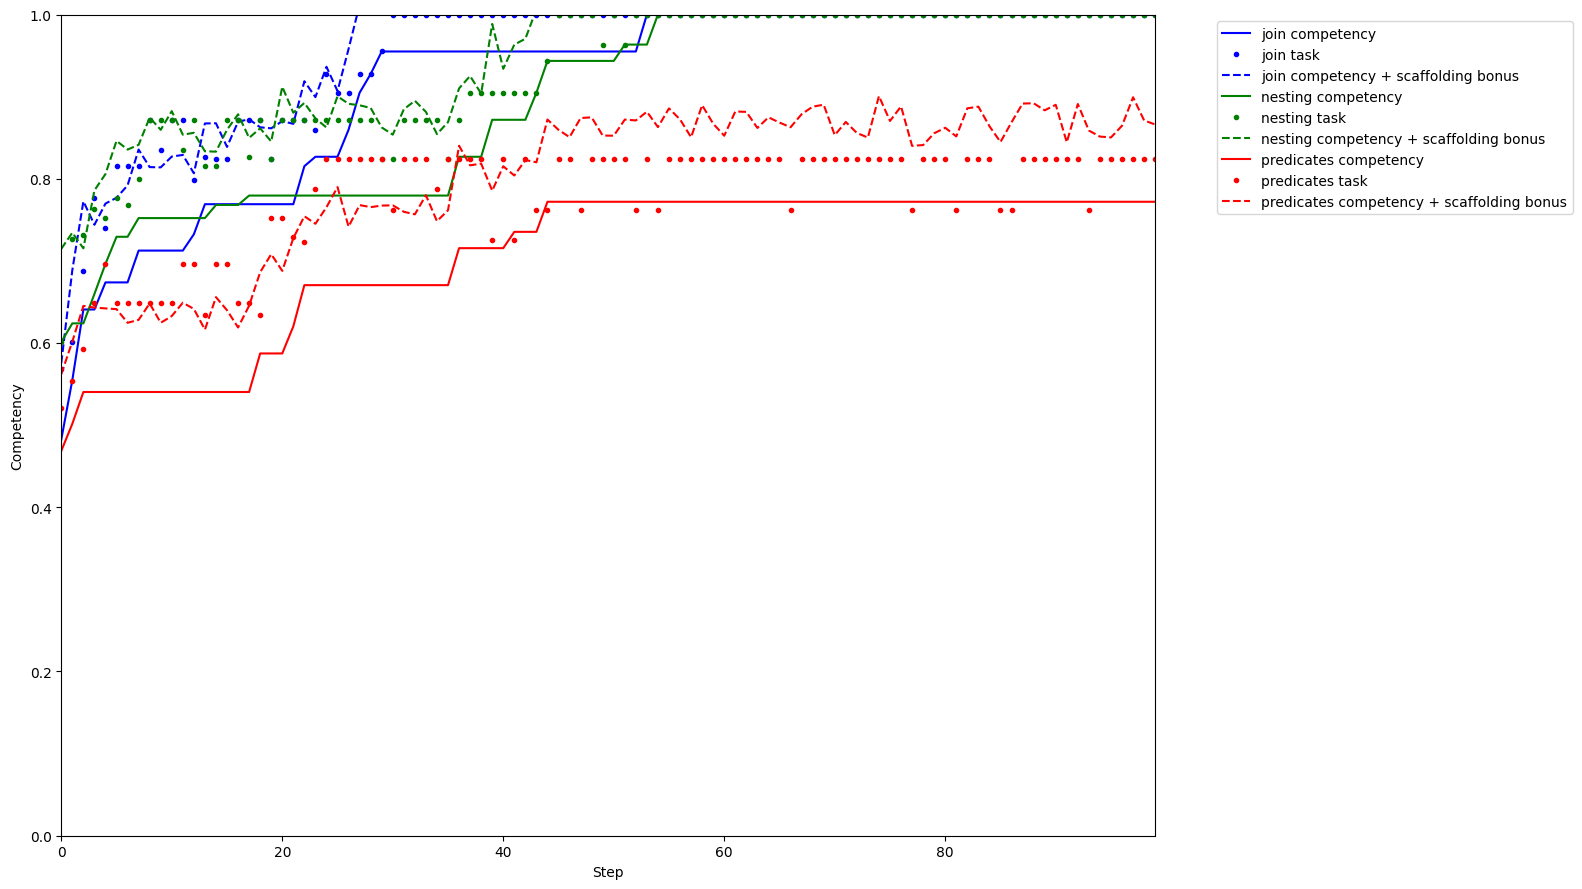

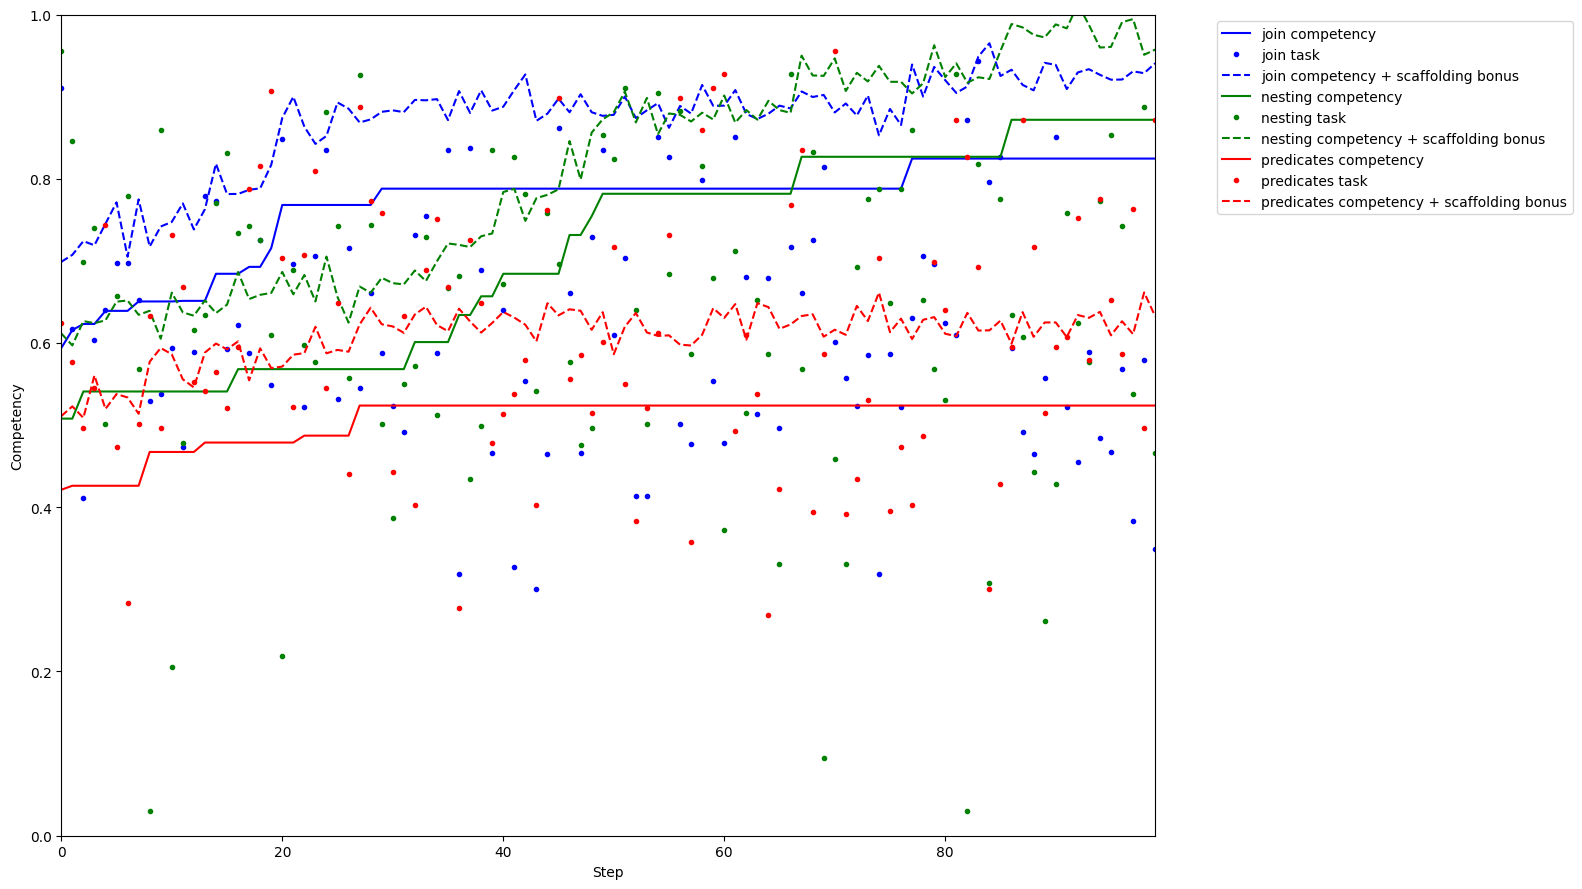

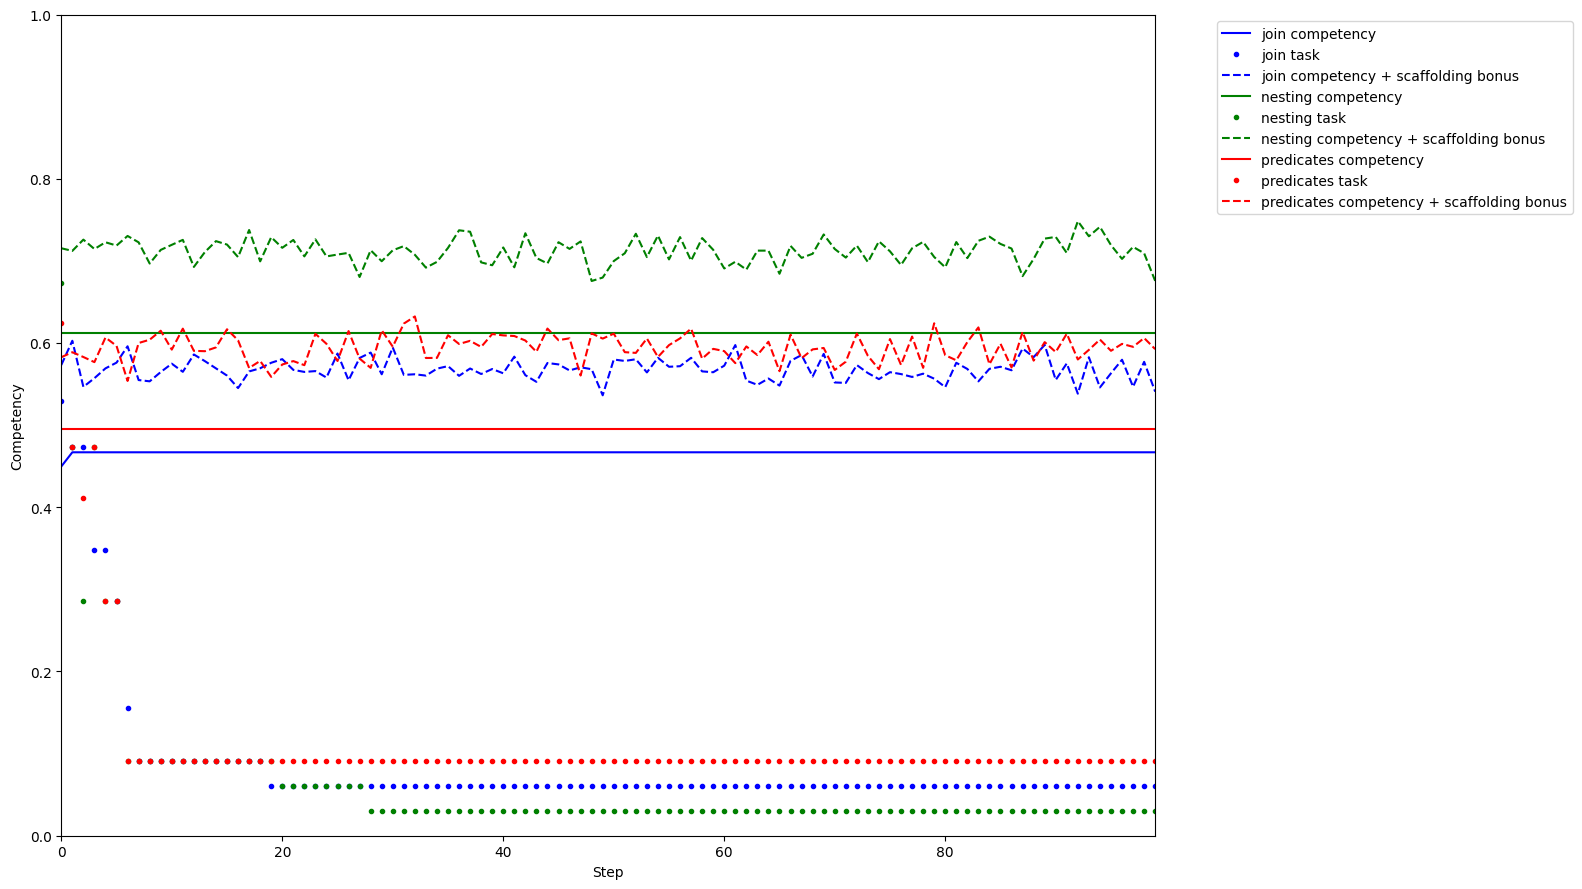

In [19]:
from simulation_plot import plot_mean_simulation_log, plot_simulation_log

plot_simulation_log(log_optimal, 1)
plot_simulation_log(log_random, 1)
# plot_simulation_log(log_dkt, 1)
plot_simulation_log(log_dkvmn, 1)
# plot_simulation_log(akt_log, 1)